In [43]:
import math
import pandas_datareader.data as web
import yfinance as yfin
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [50]:
df = yfin.download('AAPL', start='2012-01-01', end='2024-01-01')
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433822,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500648,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639426,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771563,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751300,394024400


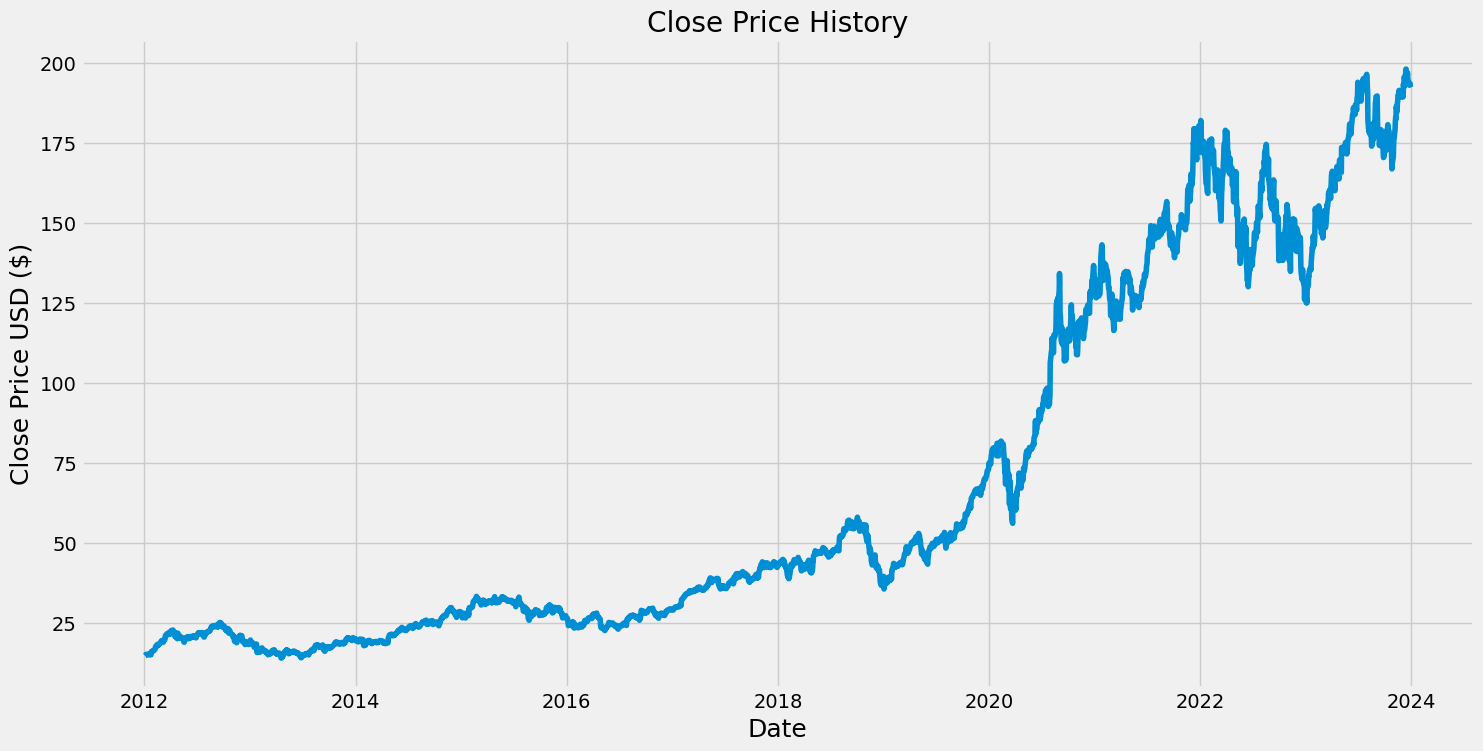

In [58]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [68]:
# Training Data Processing
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

# Create x and y labels
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60 : i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [75]:
# LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
# Train Model

model.fit(x_train, y_train, batch_size=1, epochs=2)

Epoch 1/10
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 3.4849e-04
Epoch 2/10
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 2.3473e-04
Epoch 3/10
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 2.4244e-04
Epoch 4/10
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 2.5175e-04
Epoch 5/10
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 9.5870e-05
Epoch 6/10
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 1.4230e-04
Epoch 7/10
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 1.2549e-04
Epoch 8/10
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 1.2311e-04
Epoch 9/10
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 1.2761e-04
Epoch 10/10
2355/2355 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 8.4738e-05


In [85]:
# Testing Data Set Processing
test_data = scaled_data[training_data_len - 60: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [86]:
# Predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [87]:
# Get root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

8.683856190306225

/tmp/ipykernel_1390/1542661337.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


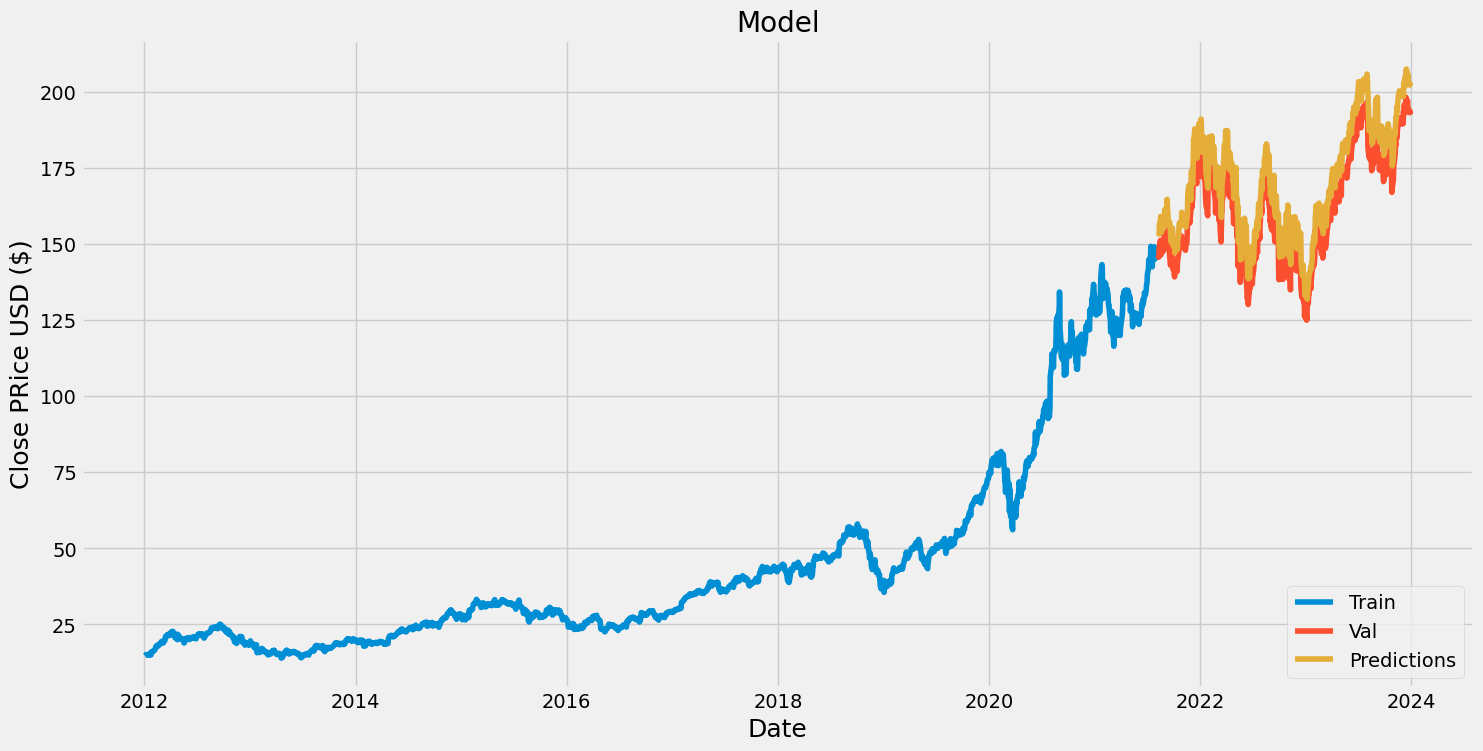

In [88]:
# Plot data

train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close PRice USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

/tmp/ipykernel_1390/3874855612.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


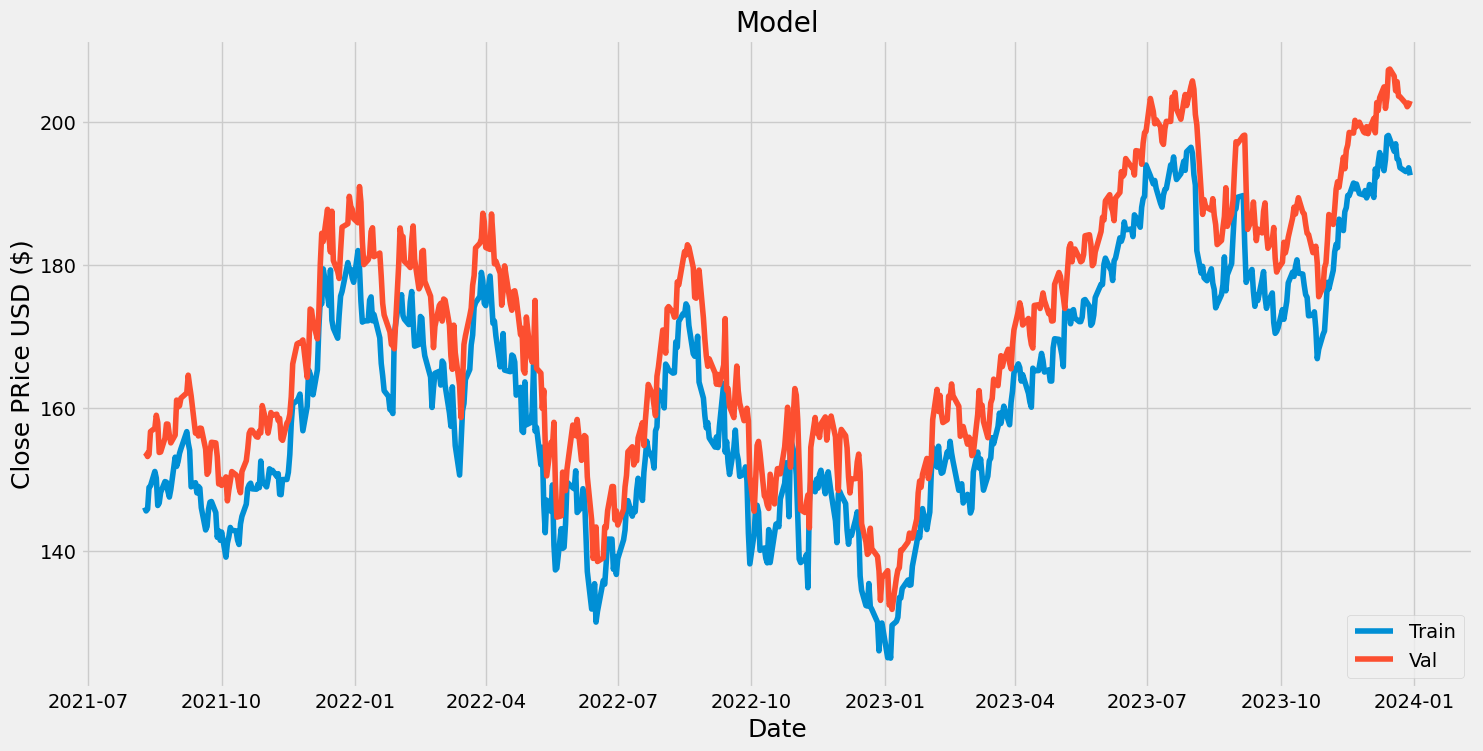

In [89]:
# Plot data

valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close PRice USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()